# Dynamic model selection

With a proportional error model, the first thing to do is to choose a dynamic model. We're gonna test several model structures. For each model, we will:
1. Estimate its optimal parameters.
2. Visually check its fit against the data
3. Evaluate its weighted residuals. Indeed, for a dynamical model $f$ of the data $y$, the error model $g$ specifies that $y \hookrightarrow \mathcal{N}(f,g)$. As a consequence, the weighted residuals $w_{i,j} = \frac{y_{i,j} - f(t_i, y_0, \theta)}{g(t_i, y_0, \theta, \xi)}$ should be distributed normally, with a null mean and unit variance ($w_{i,j} \hookrightarrow \mathcal{N} (0,1)$). The distribution of these individual residuals thus provides a check of the plausibility of an error model. (See the manuscript for notations).

The last cells of this notebook compute information-based selection criteria for each of our three dynamic models, and plot the distributions of the weighted residuals of each dynamic model.

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

def update_theme(change):
    """ display chosen theme from dropdown menu """
    name = change['new']
    html_css = set_nb_theme(name)
    display(html_css)

themes = get_themes()
print(themes)
set_nb_theme(themes[2])

['chesterish', 'grade3', 'oceans16', 'onedork']


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rc
%matplotlib inline

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

# SCB model
## Parameter Estimation
First, let's get the parameter values for the SCB model

In [3]:
from imp import reload
import numpy as np
import SCB_estimate as SCBe
import SB_estimate as SBe

import Error_Model as EM
import Custom_Estimation_Routines as CER
import Selection_Criteria as SC
reload(CER)

data = '../data/Cell_counts_DMSO.csv'  #path to dataset
duration = 5                           #how many timepoints should we consider in the estimation

DMSO_data = np.genfromtxt(data)
DMSO_data = DMSO_data[:,:duration]
t=np.arange(duration)

xlabel='Time (days)'
titles=('Self-renewing Cells (LM1)','Living Cells (DM17)','Differentiated Cells (DM17)')

#Optimization parameters:
nruns1=100 #number of independent runs of the first optimization step
nruns2=500 #number of independent runs of the second optimization step
LHS=False #should we perform LHS on initial guesses (apparently, it's not working very well with proportional error)
maxiter=int(1e6)  #maximum duration (in evaluations of the model) of one run

In [2]:
opt1=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         2,
                         (DMSO_data[0],SCBe.S,t,DMSO_data[0,0],np.array([]),False),
                         bounds=[(None,None),(0,None)],
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS,b1=opt1['parameters']
deltaSC=rhoS+0.5*np.log(DMSO_data[0,0])

opt2=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         4,
                         (DMSO_data[1:],SCBe.TB,t,[DMSO_data[1,0],0,0],np.array([rhoS,deltaSC]),False),
                         bounds=((None,None),(0,None),(None,None),(0,None)),
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoC,deltaCB,rhoB,b2=opt2['parameters']

Parameters_SCB=np.array([rhoS,deltaSC,b1,rhoC,deltaCB,rhoB,b2])

In [4]:
save=False
if save:
    np.savetxt('../data/01_Dynamic_Model_Selection/SCB_Model_%id.params'%(duration-1),Parameters_SCB)
    
load=True
if load:
    Parameters_SCB=np.genfromtxt('../data/01_Dynamic_Model_Selection/SCB_Model_%id.params'%(duration-1))
    rhoS,deltaSC,b1,rhoC,deltaCB,rhoB,b2=Parameters_SCB

L1_SCB=EM.logLikelihood_ProportionalError(np.array([rhoS,b1]),
                                               DMSO_data[0],
                                               SCBe.S,
                                               t,
                                               DMSO_data[0,0])
L2_SCB=EM.logLikelihood_ProportionalError(np.array([rhoC,deltaCB,rhoB,b2]),
                                                DMSO_data[1:],
                                                SCBe.TB,
                                                t,
                                                [DMSO_data[1,0],0,0],
                                                np.array([rhoS,deltaSC]))

names=['rhoS','deltaSC','b1','rhoC','deltaCB','rhoB','b2']

print('Parameter:\tValue:\n----------\t------')
for i in range(len(names)):
    print('%s\t\t%.4g'%(names[i],Parameters_SCB[i]))

Parameter:	Value:
----------	------
rhoS		0.5274
deltaSC		5.591
b1		0.3377
rhoC		0.4889
deltaCB		0.1826
rhoB		0.9164
b2		0.1479


### Visual fit

/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


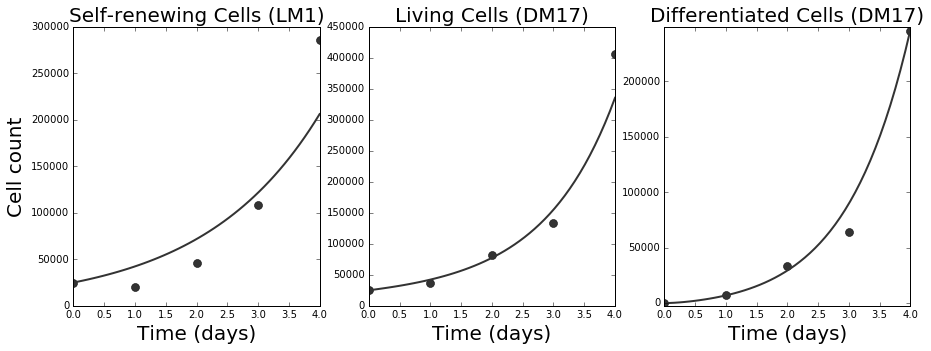

In [5]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0,duration-1)
Ss=SCBe.S(T,DMSO_data[0,0],rhoS)
TBs=SCBe.TB(T,[DMSO_data[1,0],0,0],rhoS,deltaSC,rhoC,deltaCB,rhoB)
DMSO_simul=np.vstack((Ss,TBs))

for i in range(3):
    ax[i].plot(t,DMSO_data[i],'o',markersize=8,c='0.2')
    ax[i].plot(T,DMSO_simul[i],'-',linewidth=2,c='0.2')
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(xlabel, fontsize=20)
ax[0].set_ylabel("Cell count", fontsize=20)
max_diff=np.max(np.concatenate([DMSO_simul[2], DMSO_data[2]]))
ax[2].set_ylim((-0.01*max_diff,1.01*max_diff))

savefig=False
if savefig:
    plt.savefig('../figures/01_Dynamic_Model_Selection/SCB_Model_Fit_%id.pdf'%(duration-1), bbox_inches='tight', dpi='figure')

### Residuals

In [6]:
Res_SCB_S=EM.Residuals_ProportionalError(np.array([rhoS,b1]),
                                               DMSO_data[0],
                                               SCBe.S,
                                               t,
                                               DMSO_data[0,0])
Res_SCB_TB=EM.Residuals_ProportionalError(np.array([rhoC,deltaCB,rhoB,b2]),
                                                DMSO_data[1:],
                                                SCBe.TB,
                                                t,
                                                [DMSO_data[1,0],0,0],
                                                np.array([rhoS,deltaSC]))
Res_SCB=np.concatenate((Res_SCB_S,Res_SCB_TB))

## SB model
### Parameter Estimation
First we're gonna test a model without the C compartment, and with the same estimation constraints as the SCB model (constraining $\delta_{SB}$ with the commitment experiment)

In [10]:
opt1=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         2,
                         (DMSO_data[0],SCBe.S,t,DMSO_data[0,0]),
                         bounds=((None,None),(0,None)),
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS,b1=opt1['parameters']
deltaSB=rhoS+0.5*np.log(DMSO_data[0,0])

opt2=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         2,
                         (DMSO_data[1:],SBe.TB,t,[DMSO_data[1,0],0],(rhoS,deltaSB)),
                         bounds=((None,None),(0,None)),
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoB,b2=opt2['parameters']

Parameters_SB=np.array([rhoS,deltaSB,b1,rhoB,b2])

In [7]:
save=False
if save:
    np.savetxt('../data/01_Dynamic_Model_Selection/SB_Model_%id.params'%(duration-1),Parameters_SB)

load=True
if load:
    Parameters_SB=np.genfromtxt('../data/01_Dynamic_Model_Selection/SB_Model_%id.params'%(duration-1))
    rhoS,deltaSB,b1,rhoB,b2=Parameters_SB

L1_SB=EM.logLikelihood_ProportionalError(np.array([rhoS,b1]),
                                        DMSO_data[0],
                                        SCBe.S,
                                        t,
                                        DMSO_data[0,0])
L2_SB=EM.logLikelihood_ProportionalError(np.array([rhoB,b2]),
                                         DMSO_data[1:],
                                         SBe.TB,
                                         t,
                                         [DMSO_data[1,0],0],
                                         np.array([rhoS,deltaSB]))
names=['rhoS','deltaSB','b1','rhoB','b2']

print('Parameter:\tValue:\n----------\t------')
for i in range(len(names)):
    print('%s\t\t%.4g'%(names[i],Parameters_SB[i]))

Parameter:	Value:
----------	------
rhoS		0.5274
deltaSB		5.591
b1		0.3377
rhoB		0.5608
b2		0.4542


### Visual fit

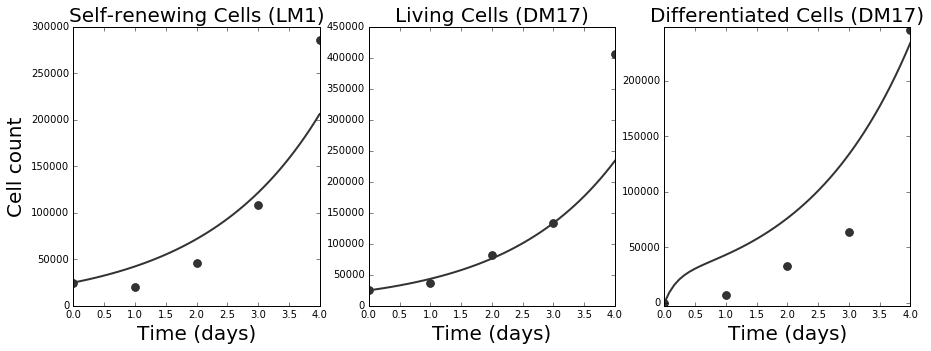

In [9]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0,4)
Ss=SCBe.S(T,DMSO_data[0,0],rhoS)
TBs=SBe.TB(T,[DMSO_data[1,0],0],rhoS,deltaSB,rhoB)
DMSO_simul=np.vstack((Ss,TBs))

for i in range(3):
    ax[i].plot(t,DMSO_data[i],'o',markersize=8,c='0.2')
    ax[i].plot(T,DMSO_simul[i],'-',linewidth=2,c='0.2')
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(xlabel, fontsize=20)
ax[0].set_ylabel("Cell count", fontsize=20)
max_diff=np.max(np.concatenate([DMSO_simul[2], DMSO_data[2]]))
ax[2].set_ylim((-0.01*max_diff,1.01*max_diff))

savefig=False
if savefig:
    plt.savefig('../figures/01_Dynamic_Model_Selection/SB_Model_Fit_%id.pdf'%(duration-1), bbox_inches='tight', dpi='figure')

### Residuals

In [10]:
Res_SB_S=EM.Residuals_ProportionalError(np.array([rhoS,b1]),
                                        DMSO_data[0],
                                        SCBe.S,
                                        t,
                                        DMSO_data[0,0])
Res_SB_TB=EM.Residuals_ProportionalError(np.array([rhoB,b2]),
                                         DMSO_data[1:],
                                         SBe.TB,
                                         t,
                                         [DMSO_data[1,0],0],
                                         np.array([rhoS,deltaSB]))
Res_SB=np.concatenate((Res_SB_S,Res_SB_TB))

## S2B Model
### Parameter estimation

In [14]:
opt1=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         2,
                         (DMSO_data[0],SCBe.S,t,DMSO_data[0,0]),
                         bounds=((None,None),(0,None)),
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS1,b1=opt1['parameters']

opt2=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         4,
                         (DMSO_data[1:],SBe.TB,t,[DMSO_data[1,0],0]),
                         bounds=((None,None),(0,None),(None,None),(0,None)),
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS2,deltaSB,rhoB,b2=opt2['parameters']

Parameters_S2B=np.array([rhoS1,b1,rhoS2,deltaSB,rhoB,b2])

In [11]:
save=False
if save:
    np.savetxt('../data/01_Dynamic_Model_Selection/S2B_Model_%id.params'%(duration-1),Parameters_S2B)

load=True
if load:
    Parameters_S2B=np.genfromtxt('../data/01_Dynamic_Model_Selection/S2B_Model_%id.params'%(duration-1))
    rhoS1,b1,rhoS2,deltaSB,rhoB,b2=Parameters_S2B

L1_S2B=EM.logLikelihood_ProportionalError(np.array([rhoS1,b1]),
                                        DMSO_data[0],
                                        SCBe.S,
                                        t,
                                        DMSO_data[0,0])
L2_S2B=EM.logLikelihood_ProportionalError(np.array([rhoS2,deltaSB,rhoB,b2]),
                                         DMSO_data[1:],
                                         SBe.TB,
                                         t,
                                         [DMSO_data[1,0],0])
names=['rhoS1','b1','rhoS2','deltaSB','rhoB','b2']

print('Parameter:\tValue:\n----------\t------')
for i in range(len(names)):
    print('%s\t\t%.4g'%(names[i],Parameters_S2B[i]))

Parameter:	Value:
----------	------
rhoS1		0.5274
b1		0.3377
rhoS2		0.4741
deltaSB		0.1487
rhoB		0.9556
b2		0.145


### Visual Fit

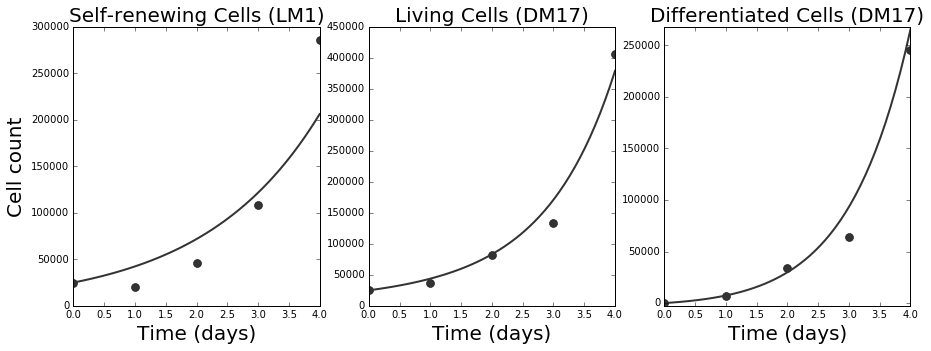

In [12]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0,4)
Ss=SCBe.S(T,DMSO_data[0,0],rhoS1)
TBs=SBe.TB(T,[DMSO_data[1,0],0],rhoS1,deltaSB,rhoB)
DMSO_simul=np.vstack((Ss,TBs))

for i in range(3):
    ax[i].plot(t,DMSO_data[i],'o',markersize=8,c='0.2')
    ax[i].plot(T,DMSO_simul[i],'-',linewidth=2,c='0.2')
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(xlabel, fontsize=20)
ax[0].set_ylabel("Cell count", fontsize=20)
max_diff=np.max(np.concatenate([DMSO_simul[2], DMSO_data[2]]))
ax[2].set_ylim((-0.01*max_diff,1.01*max_diff))

savefig=False
if savefig:
    plt.savefig('../figures/01_Dynamic_Model_Selection/S2B_Model_Fit_%id.pdf'%(duration-1), bbox_inches='tight', dpi='figure')

### Residuals

In [13]:
Res_S2B_S=EM.Residuals_ProportionalError(np.array([rhoS1,b1]),
                                        DMSO_data[0],
                                        SCBe.S,
                                        t,
                                        DMSO_data[0,0])
Res_S2B_TB=EM.Residuals_ProportionalError(np.array([rhoS2,deltaSB,rhoB,b2]),
                                         DMSO_data[1:],
                                         SBe.TB,
                                         t,
                                         [DMSO_data[1,0],0])
Res_S2B=np.concatenate((Res_S2B_S,Res_S2B_TB))

## Residual distributions
The red line is the distribution for $\mathcal{N}(0,1)$. The histograms show the distribution of the weighted residuals for each dynamic model

/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


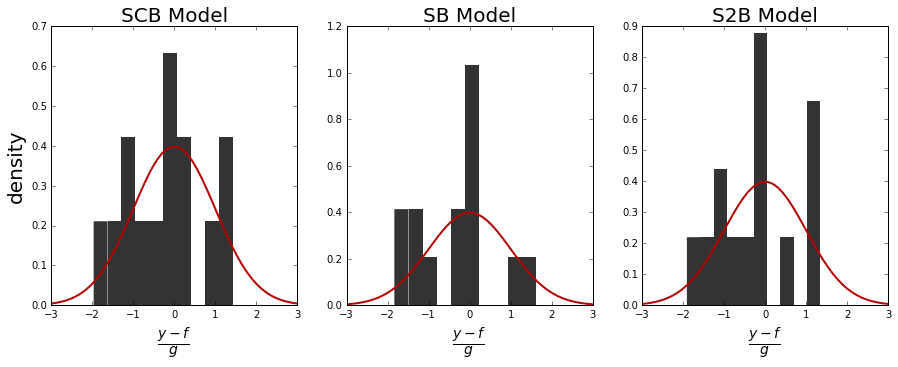

In [14]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

xrange=np.linspace(-3,3)
titles=('SCB Model','SB Model','S2B Model')

Res=(Res_SCB, Res_SB, Res_S2B)

for i in range(3):
    ax[i].hist(Res[i],bins=10,facecolor='0.2',normed=1,edgecolor='none')
    ax[i].plot(xrange, mlab.normpdf(xrange,0,1), '-', c='#b50303', linewidth=2)
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(r'$\frac{y-f}{g}$', fontsize=20)
ax[0].set_ylabel('density', fontsize=20)

savefig=False
if savefig:
    plt.savefig('../figures/01_Dynamic_Model_Selection/Dynamic_Models_Residuals_distributions_%id.pdf'%(duration-1),dpi='figure',bbox_inches='tight')

## Model Selection

In [15]:
line_names=('SCB','SB','S2B')
column_names=('Model','-2log(L1)','-2log(L2)','AIC','AICc','D_AICc','w_AICc')

L1 = (L1_SCB,L1_SB,L1_S2B)  #likelihood in the first estimation step
L2 = (L2_SCB,L2_SB,L2_S2B)  #likelihood in the second estimation step
k  = (6,5,6)    #number of parameters
n  = (3*duration,3*duration,3*duration) #sample size
AIC = list(SC.AIC(L1[i]+L2[i],k[i]) for i in range(3))
AICc= list(SC.AICc(L1[i]+L2[i],n[i],k[i]) for i in range(3))
D_AICc = np.array(AICc)-np.min(AICc)
w_AICc = np.exp(-0.5*D_AICc)/np.sum(np.exp(-0.5*D_AICc))

header=''
for i in range(len(column_names)):
    header+='%s:\t'%column_names[i]
header+='\n'
for i in range(len(column_names)):
    header+='%s\t'%('-'*(len(column_names[i])+1))

print(header)
for i in range(len(line_names)):
    line=line_names[i]+'\t'
    line+='%.4g\t\t'%L1[i]
    line+='%.4g\t\t'%L2[i]
    line+='%.4g\t'%AIC[i]
    line+='%.4g\t'%AICc[i]
    line+='%.4g\t'%D_AICc[i]
    line+='%.6g\t'%w_AICc[i]
    print(line)

Model:	-2log(L1):	-2log(L2):	AIC:	AICc:	D_AICc:	w_AICc:	
------	----------	----------	----	-----	-------	-------	
SCB	106		173.9		291.9	302.4	0.401	0.450027	
SB	106		199.4		315.4	322	20.05	2.4367e-05	
S2B	106		173.5		291.5	302	0	0.549949	
